## 基本RNN模型

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

定义激活函数 tanh 和它的导数

In [14]:
def tanh(x):
    return np.tanh(x)


def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

In [13]:

class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        # 初始化权重和偏置
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01  # 输入到隐藏层
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # 隐藏层到隐藏层
        self.Why = np.random.randn(output_size, hidden_size) * 0.01  # 隐藏层到输出层
        self.bh = np.zeros((hidden_size, 1))  # 隐藏层偏置
        self.by = np.zeros((output_size, 1))  # 输出层偏置

        # 缓存用于反向传播
        self.hidden_states = []
        self.inputs = []
        self.outputs = []

    def forward(self, inputs):
        # 初始化隐藏状态
        h_prev = np.zeros((self.Whh.shape[0], 1))
        self.hidden_states = [h_prev]
        self.inputs = inputs
        self.outputs = []

        # 前向传播
        for x in inputs:
            x = x.reshape(-1, 1)  # 将输入转换为列向量
            h_t = tanh(np.dot(self.Wxh, x) +
                       np.dot(self.Whh, h_prev) + self.bh)
            y_t = np.dot(self.Why, h_t) + self.by

            # 保存中间结果
            self.hidden_states.append(h_t)
            self.outputs.append(y_t)
            h_prev = h_t

        return self.outputs

    def backward(self, dY):
        # 初始化梯度
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(
            self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dh_next = np.zeros_like(self.hidden_states[0])

        # 反向传播
        for t in reversed(range(len(self.inputs))):
            x = self.inputs[t].reshape(-1, 1)
            h_t = self.hidden_states[t + 1]
            h_prev = self.hidden_states[t]

            # 计算输出层的梯度
            dy = dY[t]
            dWhy += np.dot(dy, h_t.T)
            dby += dy

            # 计算隐藏层的梯度
            dh = np.dot(self.Why.T, dy) + dh_next
            dh_raw = tanh_derivative(h_t) * dh

            dbh += dh_raw
            dWxh += np.dot(dh_raw, x.T)
            dWhh += np.dot(dh_raw, h_prev.T)
            dh_next = np.dot(self.Whh.T, dh_raw)

        # 更新参数
        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby

In [9]:


# 2. 设置超参数
input_size = 10  # 输入特征的维度
hidden_size = 20  # 隐藏层的维度
output_size = 1  # 输出的维度
sequence_length = 5  # 序列长度
batch_size = 3  # 批次大小

In [10]:

# 3. 创建模型实例
model = SimpleRNN(input_size, hidden_size, output_size)

# 4. 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 5. 创建一些随机数据
x = torch.randn(batch_size, sequence_length, input_size)  # 输入数据
y = torch.randn(batch_size, output_size)  # 目标数据

# 6. 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # 前向传播
    outputs = model(x)
    loss = criterion(outputs, y)

    # 反向传播和优化

    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0557
Epoch [20/100], Loss: 0.0169
Epoch [30/100], Loss: 0.0040
Epoch [40/100], Loss: 0.0015
Epoch [50/100], Loss: 0.0004
Epoch [60/100], Loss: 0.0001
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


In [11]:

# 7. 测试模型
with torch.no_grad():
    test_input = torch.randn(1, sequence_length, input_size)
    predicted_output = model(test_input)
    print("Predicted Output:", predicted_output)

Predicted Output: tensor([[-0.5289]])


## LSTM网络

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

定义激活函数 sigmoid 和 tanh

In [40]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def tanh(x):
    return np.tanh(x)

定义LSTM的前向传播和反向传播

In [34]:
class LSTMLayer:
    def __init__(self, input_size, hidden_size):
        """
        初始化 LSTM 层。

        参数:
        - input_size: 输入特征的维度
        - hidden_size: 隐藏状态的维度
        """
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 初始化权重和偏置
        # 遗忘门参数
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bf = np.zeros((hidden_size, 1))

        # 输入门参数
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bi = np.zeros((hidden_size, 1))

        # 候选细胞状态参数
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bc = np.zeros((hidden_size, 1))

        # 输出门参数
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bo = np.zeros((hidden_size, 1))

        # 初始化隐藏状态和细胞状态
        self.h = np.zeros((hidden_size, 1))
        self.C = np.zeros((hidden_size, 1))

        # 缓存用于反向传播
        self.cache = []

    def forward(self, x):
        # 将输入和隐藏状态拼接
        combined = np.vstack((self.h, x.reshape(-1, 1)))

        # 遗忘门
        ft = sigmoid(np.dot(self.Wf, combined) + self.bf)

        # 输入门
        it = sigmoid(np.dot(self.Wi, combined) + self.bi)

        # 候选细胞状态
        Ct_candidate = tanh(np.dot(self.Wc, combined) + self.bc)

        # 更新细胞状态
        self.C = ft * self.C + it * Ct_candidate

        # 输出门
        ot = sigmoid(np.dot(self.Wo, combined) + self.bo)

        # 更新隐藏状态
        self.h = ot * tanh(self.C)

        # 保存中间结果用于反向传播
        self.cache.append((combined, ft, it, Ct_candidate, ot, self.C, self.h))

        return self.h

    def backward(self, dY, learning_rate=0.1):
        # 初始化梯度
        dWf, dWi, dWc, dWo = np.zeros_like(self.Wf), np.zeros_like(
            self.Wi), np.zeros_like(self.Wc), np.zeros_like(self.Wo)
        dbf, dbi, dbc, dbo = np.zeros_like(self.bf), np.zeros_like(
            self.bi), np.zeros_like(self.bc), np.zeros_like(self.bo)
        dh_next = np.zeros_like(self.h)
        dC_next = np.zeros_like(self.C)

        # 反向传播
        for t in reversed(range(len(self.cache))):
            combined, ft, it, Ct_candidate, ot, Ct, ht = self.cache[t]

            # 计算隐藏状态的梯度
            dh = dY[t] + dh_next

            # 计算输出门的梯度
            dot = dh * tanh(Ct) * ot * (1 - ot)
            dWo += np.dot(dot, combined.T)
            dbo += dot

            # 计算细胞状态的梯度
            dCt = dh * ot * (1 - tanh(Ct) ** 2) + dC_next
            dft = dCt * Ct * ft * (1 - ft)
            dit = dCt * Ct_candidate * it * (1 - it)
            dCt_candidate = dCt * it * (1 - Ct_candidate ** 2)

            # 更新参数梯度
            dWf += np.dot(dft, combined.T)
            dbf += dft
            dWi += np.dot(dit, combined.T)
            dbi += dit
            dWc += np.dot(dCt_candidate, combined.T)
            dbc += dCt_candidate

            # 计算下一个时间步的梯度
            dcombined = np.dot(self.Wf.T, dft) + np.dot(self.Wi.T, dit) + \
                np.dot(self.Wc.T, dCt_candidate) + np.dot(self.Wo.T, dot)
            dh_next = dcombined[:self.hidden_size, :]
            dC_next = ft * dCt

        # 更新参数
        self.Wf -= learning_rate * dWf
        self.Wi -= learning_rate * dWi
        self.Wc -= learning_rate * dWc
        self.Wo -= learning_rate * dWo
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bc -= learning_rate * dbc
        self.bo -= learning_rate * dbo

In [41]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        初始化 LSTM 模型。

        参数:
        - input_size: 输入特征的维度
        - hidden_size: 隐藏层的维度
        - output_size: 输出特征的维度
        - num_layers: LSTM 的层数
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定义 LSTM 层
        self.lstm = LSTMLayer(input_size, hidden_size,
                              num_layers, batch_first=True)

        # 定义全连接层，将 LSTM 的输出映射到最终的输出空间
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        前向传播。

        参数:
        - x: 输入数据，形状为 (batch_size, sequence_length, input_size)

        返回:
        - output: 模型输出，形状为 (batch_size, output_size)
        """
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # LSTM 前向传播
        out, _ = self.lstm(x, (h0, c0))

        # 只取最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

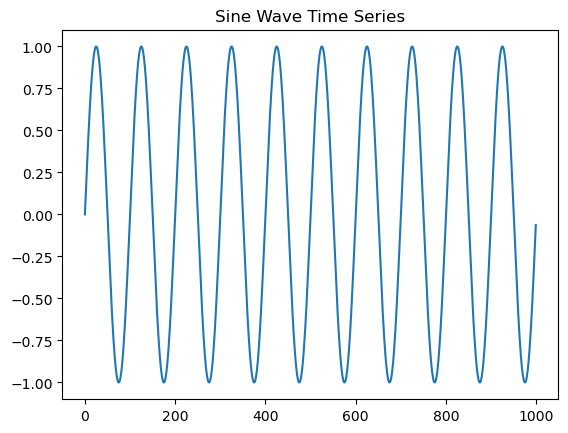

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# 生成正弦波数据


def generate_sine_wave(length, frequency=0.01):
    x = np.arange(length)
    y = np.sin(2 * np.pi * frequency * x)
    return y


# 生成数据
sequence_length = 1000
data = generate_sine_wave(sequence_length)

# 可视化数据
plt.plot(data)
plt.title("Sine Wave Time Series")
plt.show()

In [43]:
# 将时间序列数据转换为输入和输出对
def create_dataset(data, seq_length):
    inputs = []
    targets = []
    for i in range(len(data) - seq_length):
        inputs.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(inputs), np.array(targets)


# 设置序列长度
seq_length = 20
inputs, targets = create_dataset(data, seq_length)

# 将数据转换为 PyTorch 张量
inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(-1)  # 添加一个维度
targets = torch.tensor(targets, dtype=torch.float32)

# 打印数据形状
print("Inputs shape:", inputs.shape)  # (num_samples, seq_length, input_size)
print("Targets shape:", targets.shape)  # (num_samples)

Inputs shape: torch.Size([980, 20, 1])
Targets shape: torch.Size([980])


In [44]:
# 超参数
input_size = 1  # 输入特征维度
hidden_size = 50  # 隐藏层大小
output_size = 1  # 输出维度
num_layers = 1  # LSTM 层数
learning_rate = 0.01
num_epochs = 100

# 创建模型实例
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

TypeError: LSTMLayer.__init__() got an unexpected keyword argument 'batch_first'

In [45]:
# 超参数
input_size = 1  # 输入特征维度
hidden_size = 50  # 隐藏层大小
output_size = 1  # 输出维度
num_layers = 1  # LSTM 层数
learning_rate = 0.01
num_epochs = 100

# 创建模型实例
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

TypeError: LSTMLayer.__init__() got an unexpected keyword argument 'batch_first'

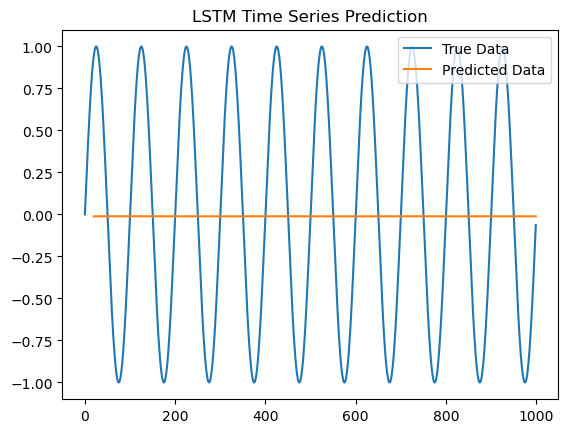

In [46]:
# 测试模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    test_input = inputs[0].unsqueeze(0)  # 取第一个样本
    predicted_output = model(test_input)

# 可视化结果
plt.plot(data, label="True Data")
plt.plot(np.arange(seq_length, sequence_length),
         outputs.detach().numpy(), label="Predicted Data")
plt.legend()
plt.title("LSTM Time Series Prediction")
plt.show()

### 手动实现

In [58]:
import numpy as np

# 定义激活函数 sigmoid 和 tanh


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def tanh(x):
    return np.tanh(x)


class ManualLSTMLayer:
    def __init__(self, input_size, hidden_size):
        """
        初始化手动实现的 LSTM 层。

        参数:
        - input_size: 输入特征的维度
        - hidden_size: 隐藏状态的维度
        """
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 初始化权重和偏置
        # 遗忘门参数
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bf = np.zeros((hidden_size, 1))

        # 输入门参数
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bi = np.zeros((hidden_size, 1))

        # 候选细胞状态参数
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bc = np.zeros((hidden_size, 1))

        # 输出门参数
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bo = np.zeros((hidden_size, 1))

        # 初始化隐藏状态和细胞状态
        self.h = None  # 形状为 (batch_size, hidden_size)
        self.C = None  # 形状为 (batch_size, hidden_size)

        # 缓存用于反向传播
        self.cache = []

    def forward(self, x):
        """
        前向传播。

        参数:
        - x: 输入数据，形状为 (batch_size, input_size)

        返回:
        - h: 当前时间步的隐藏状态，形状为 (batch_size, hidden_size)
        """
        batch_size = x.shape[0]

        # 如果是第一次调用，初始化隐藏状态和细胞状态
        if self.h is None:
            self.h = np.zeros((batch_size, self.hidden_size))
            self.C = np.zeros((batch_size, self.hidden_size))

        # 将输入和隐藏状态拼接
        # 形状为 (batch_size, input_size + hidden_size)
        combined = np.hstack((x, self.h))

        # 遗忘门
        # 形状为 (batch_size, hidden_size)
        ft = sigmoid(np.dot(combined, self.Wf.T) + self.bf.T)

        # 输入门
        # 形状为 (batch_size, hidden_size)
        it = sigmoid(np.dot(combined, self.Wi.T) + self.bi.T)

        # 候选细胞状态
        # 形状为 (batch_size, hidden_size)
        Ct_candidate = tanh(np.dot(combined, self.Wc.T) + self.bc.T)

        # 更新细胞状态
        # 形状为 (batch_size, hidden_size)
        self.C = ft * self.C + it * Ct_candidate

        # 输出门
        # 形状为 (batch_size, hidden_size)
        ot = sigmoid(np.dot(combined, self.Wo.T) + self.bo.T)

        # 更新隐藏状态
        self.h = ot * tanh(self.C)  # 形状为 (batch_size, hidden_size)

        # 保存中间结果用于反向传播
        self.cache.append((combined, ft, it, Ct_candidate, ot, self.C, self.h))

        return self.h

In [59]:
import torch
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        初始化 LSTM 模型。

        参数:
        - input_size: 输入特征的维度
        - hidden_size: 隐藏状态的维度
        - output_size: 输出特征的维度
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # 使用手动实现的 LSTM 层
        self.lstm = ManualLSTMLayer(input_size, hidden_size)

        # 定义全连接层，将 LSTM 的输出映射到最终的输出空间
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        前向传播。

        参数:
        - x: 输入数据，形状为 (batch_size, sequence_length, input_size)

        返回:
        - output: 模型输出，形状为 (batch_size, output_size)
        """
        batch_size, seq_length, input_size = x.shape

        # 初始化隐藏状态
        self.lstm.h = np.zeros((batch_size, self.hidden_size))
        self.lstm.C = np.zeros((batch_size, self.hidden_size))

        # 存储每个时间步的输出
        outputs = []

        # 遍历每个时间步
        for t in range(seq_length):
            # 获取当前时间步的输入
            # 转换为 NumPy 数组，形状为 (batch_size, input_size)
            xt = x[:, t, :].numpy()

            # 手动 LSTM 前向传播
            ht = self.lstm.forward(xt)

            # 保存隐藏状态
            outputs.append(ht)

        # 将输出转换为 PyTorch 张量
        outputs = torch.tensor(np.array(outputs), dtype=torch.float32)

        # 只取最后一个时间步的输出
        out = self.fc(outputs[-1])
        return out

In [60]:
# 超参数
input_size = 1
hidden_size = 50
output_size = 1
learning_rate = 0.01
num_epochs = 100

# 创建模型实例
model = LSTMModel(input_size, hidden_size, output_size)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

d:\Python\CondaEnvs\Pytorch\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([980])) that is different to the input size (torch.Size([980, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.5029
Epoch [20/100], Loss: 0.5028
Epoch [30/100], Loss: 0.5027
Epoch [40/100], Loss: 0.5027
Epoch [50/100], Loss: 0.5027
Epoch [60/100], Loss: 0.5027
Epoch [70/100], Loss: 0.5027
Epoch [80/100], Loss: 0.5027
Epoch [90/100], Loss: 0.5027
Epoch [100/100], Loss: 0.5027
